# Mapping Multiple Variables: Cal-Adapt
### Authors

Samantha Stevenson sstevenson@ucsb.edu

### Table of Contents

[Goals](#purpose)

[Import Packages](#path)

[Load and Query the Cal-Adapt Catalog](#load)

[Read in Data](#xarray)

[Make Maps](#maps)

<a id='purpose'></a> 
## **Goals**

In this tutorial, we will continue working with the [Cal-Adapt Analytics Engine Data Catalog](https://analytics.cal-adapt.org/data/catalog/), to visualize multiple geospatial data fields on the same plot!

Skills provided in this tutorial:
- Mapping, including displaying geospatial features using shape files;
- Using **vector** plots to display multiple variables on a map at once!

<a id='path'></a> 
## **Import Packages**

As always, we begin by importing the necessary packages for our analysis. This tutorial assumes that you have all the packages needed for the [Plotting Regional Time Series](https://github.com/climate-datalab/EnsembleAnalysis/blob/main/2.%20Plotting%20Regional%20Time%20Series%20Using%20Shapefiles.ipynb) tutorial in the EnsembleAnalysis repo installed; if you need more details on these packages, please see that tutorial.

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import intake
import s3fs
import geopandas as gpd
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from shapely.geometry import Point
import scipy.stats as stats

<a id='load'></a> 
## **Load and Query the Cal-Adapt Catalog**

Now we can use `intake` to load the information associated with the Cal-Adapt holdings on Amazon Web Services!

For detailed background information on Cal-Adapt, see either:
- [tutorial 1 in this repo](https://github.com/climate-datalab/Cal-Adapt-diagnostics/blob/677b41a18feb2bdd6fc2468a9aff23cc6652b781/1.%20Mapping%20Downscaled%20Products.ipynb)
- [cal-adapt.org](http://cal-adapt.org)

In [2]:
# Open the Cal-Adapt data catalog, store as a variable
catalog = intake.open_esm_datastore('https://cadcat.s3.amazonaws.com/cae-collection.json')

Let's build on the activities we were working on in tutorial "1. Mapping Downscaled Products" in this repository. We were using the downscaled simulations from either LOCA2 or WRF, run with the CESM2, to visualize changes in precipitation under future warming scenarios. Now let's figure out how to extend that approach and add _wind vectors_ to the plot, so that we can see how patterns of atmospheric circulation might change as well!

We can specify some of the necessary search terms in the catalog to extract that information:

In [3]:
# Specify search terms to query catalog 
# activity_id: which downscaling technique do you want?
activity_id = ["WRF"]

# experiment_id: which historical/future scenario do you want?
experiment_ids = ["historical", "ssp370"]

# table_id: which time resolution do you want?
table_id = ["day"]

# source_id: which model do you want?
source_id = ["CESM2"]

# institution_id: which research institution do you want?
institution_id = ["UCSD"]

The above specifies that we would like daily information for both the historical and future (SSP3-7.0) periods from CESM2; I've also gone ahead and stated that we'll use the WRF downscaling performed at UCSD (for this particular model, there are two options which use different coordinate names - that's something we can deal with, but for simplicity we'll just use one right now).

Let's extract the catalog information for the above query, then see what variables are available to plot!

In [5]:
# Search through catalog, store results
wrf_res = catalog.search(activity_id=activity_id, experiment_id=experiment_ids,
                     table_id=table_id, source_id=source_id, institution_id=institution_id)

# Create a data frame
wrf_df = wrf_res.df

# Plot variables available
print(wrf_df.variable_id.unique())

<ArrowExtensionArray>
[      'prec',         'q2',     'rh_max',     'rh_min',     'sw_dwn',
      't2max',      't2min',        'u10',        'v10', 'wspd10mean']
Length: 10, dtype: large_string[pyarrow]


The first entry returned is the `prec` variable that's the WRF version of precipitation - we learned about how to work with that in the previous tutorial. 

The other two we'll want here are:
- u10: the _east-west_ wind at an elevation of 10 meters;
- v10: the _north-south_ wind at the same 10 meter elevation.

If we extract both of those, we can use them to specify the x and y _components_ of our wind vector later on!

Now that we have the full data frame for all the WRF information, we can extract the pieces of it that go with all our variables: there will be three in total this time!

In [8]:
# Make data frames for just precip, zonal wind, and meridional wind
prec_cesm2df = wrf_df[(wrf_df["variable_id"] == "t2max")]
u10_cesm2df = wrf_df[(wrf_df["variable_id"] == "u10")]
v10_cesm2df = wrf_df[(wrf_df["variable_id"] == "v10")]

# Display data frame associated with results
display(prec_cesm2df)
display(u10_cesm2df)
display(v10_cesm2df)

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,path
5,WRF,UCSD,CESM2,historical,r11i1p1f1,day,t2max,d03,s3://cadcat/wrf/ucsd/cesm2/historical/r11i1p1f...
15,WRF,UCSD,CESM2,ssp370,r11i1p1f1,day,t2max,d03,s3://cadcat/wrf/ucsd/cesm2/ssp370/r11i1p1f1/da...


,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,path
7,WRF,UCSD,CESM2,historical,r11i1p1f1,day,u10,d03,s3://cadcat/wrf/ucsd/cesm2/historical/r11i1p1f...
17,WRF,UCSD,CESM2,ssp370,r11i1p1f1,day,u10,d03,s3://cadcat/wrf/ucsd/cesm2/ssp370/r11i1p1f1/da...


,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,path
8,WRF,UCSD,CESM2,historical,r11i1p1f1,day,v10,d03,s3://cadcat/wrf/ucsd/cesm2/historical/r11i1p1f...
18,WRF,UCSD,CESM2,ssp370,r11i1p1f1,day,v10,d03,s3://cadcat/wrf/ucsd/cesm2/ssp370/r11i1p1f1/da...


In [9]:
# Define list of ensemble members
# (in this case there's only one but that might not always be true)
mems = ["r11i1p1f1"]

In [17]:
# Define an empty list
cesm2_wrf_prec = []
cesm2_wrf_u10 = []
cesm2_wrf_v10 = []

# Loop over all common ensemble members; leave the loop structure
# so that we can change to using multiple members if need be
for mem in range(len(mems)):
    print(mems[mem])

    # Extract HISTORICAL member of interest
    # precip
    prec_cesm2df = wrf_df[(wrf_df["variable_id"] == "t2max") 
                          & (wrf_df["experiment_id"] == "historical")
                         & (wrf_df["member_id"] == mems[mem])]
    # east-west wind
    u10_cesm2df = wrf_df[(wrf_df["variable_id"] == "u10") 
                          & (wrf_df["experiment_id"] == "historical")
                        & (wrf_df["member_id"] == mems[mem])]
    # north-south wind
    v10_cesm2df = wrf_df[(wrf_df["variable_id"] == "v10") 
                          & (wrf_df["experiment_id"] == "historical")
                        & (wrf_df["member_id"] == mems[mem])]

    display(u10_cesm2df)
    
    # Store HISTORICAL data as xarray
    hist_prec = xr.open_zarr(prec_cesm2df['path'].iloc[0], storage_options={'anon': True})
    hist_u10 = xr.open_zarr(u10_cesm2df['path'].iloc[0], storage_options={'anon': True})
    hist_v10 = xr.open_zarr(v10_cesm2df['path'].iloc[0], storage_options={'anon': True})

    # Do the same thing for the SSP ensemble
    # precip
    prec_cesm2df = wrf_df[(wrf_df["variable_id"] == "t2max") 
                          & (wrf_df["experiment_id"] == "ssp370")
                         & (wrf_df["member_id"] == mems[mem])]
    # east-west wind
    u10_cesm2df = wrf_df[(wrf_df["variable_id"] == "u10") 
                          & (wrf_df["experiment_id"] == "ssp370")
                        & (wrf_df["member_id"] == mems[mem])]
    # north-south wind
    v10_cesm2df = wrf_df[(wrf_df["variable_id"] == "v10") 
                          & (wrf_df["experiment_id"] == "ssp370")
                        & (wrf_df["member_id"] == mems[mem])]
    
     
    # Store SSP3-7.0 data as xarray
    ssp370_prec = xr.open_zarr(prec_cesm2df['path'].iloc[0], storage_options={'anon': True})
    ssp370_u10 = xr.open_zarr(u10_cesm2df['path'].iloc[0], storage_options={'anon': True})
    ssp370_v10 = xr.open_zarr(v10_cesm2df['path'].iloc[0], storage_options={'anon': True})
    
    # Concatenate historical, SSP information
    prec_data = xr.concat([hist_prec, ssp370_prec], dim="time")
    u10_data = xr.concat([hist_u10, ssp370_u10], dim="time")
    v10_data = xr.concat([hist_v10, ssp370_v10], dim="time")
    
    # Add to list
    cesm2_wrf_prec.append(prec_data)
    cesm2_wrf_u10.append(u10_data)
    cesm2_wrf_v10.append(v10_data)


r11i1p1f1


,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,path
7,WRF,UCSD,CESM2,historical,r11i1p1f1,day,u10,d03,s3://cadcat/wrf/ucsd/cesm2/historical/r11i1p1f...


Now we follow our standard steps of concatenating the data into xarray objects - one for each variable - and adding the member names as values in the new "member" dimension!

In [18]:
# Concatenate the list into a single xarray object
cesm2_wrf_prec = xr.concat(cesm2_wrf_prec, dim="member")
cesm2_wrf_u10 = xr.concat(cesm2_wrf_u10, dim="member")
cesm2_wrf_v10 = xr.concat(cesm2_wrf_v10, dim="member")

# Store the actual member information as values of the new dimension
cesm2_wrf_prec = cesm2_wrf_prec.assign_coords(member=("member", mems))
cesm2_wrf_u10 = cesm2_wrf_u10.assign_coords(member=("member", mems))
cesm2_wrf_v10 = cesm2_wrf_v10.assign_coords(member=("member", mems))


<a id='maps'></a> 
## **Make Maps**

Now that the initial data I/O process is done, we need to format the data into something that can be added to a two-dimensional plot. We can continue with the same process that was used in tutorial 1:
- calculating averages over different time periods and computing the difference to see the epoch change;
- averaging over the member dimension to calculate the ensemble mean

Again we can adopt the definitions of "historical" and "late-century" periods provided by the state of California in the runup to the California Fifth Climate Change Assessment: 1981-2010 and 2071-2100.

### **Compute time, ensemble averages**

The code chunk below extracts data for the historical ("early") and late-century ("late") periods using `.sel()` and `.slice()`, as usual. To make the code a bit shorter, I've also _combined_ this with the `.mean(dim="time")` portion of the command - Python lets you stack commands together into a single line, which can come in quite handy sometimes!

Once the epoch averages are calculated, it's easy to just compute the difference between them:

In [19]:
# Get data for an earlier period
cesm2_wrfprec_early = cesm2_wrf_prec.sel(time=slice("1981-01-01", "2010-12-31")).mean(dim="time")
cesm2_wrfu10_early = cesm2_wrf_u10.sel(time=slice("1981-01-01", "2010-12-31")).mean(dim="time")
cesm2_wrfv10_early = cesm2_wrf_v10.sel(time=slice("1981-01-01", "2010-12-31")).mean(dim="time")

# Get data for a later period
cesm2_wrfprec_late = cesm2_wrf_prec.sel(time=slice("2071-01-01", "2100-12-31")).mean(dim="time")
cesm2_wrfu10_late = cesm2_wrf_u10.sel(time=slice("2071-01-01", "2100-12-31")).mean(dim="time")
cesm2_wrfv10_late = cesm2_wrf_v10.sel(time=slice("2071-01-01", "2100-12-31")).mean(dim="time")

# Calculate the differences
cesm2_wrfprec_diff = cesm2_wrfprec_late - cesm2_wrfprec_early
cesm2_wrfu10_diff = cesm2_wrfu10_late - cesm2_wrfu10_early
cesm2_wrfv10_diff = cesm2_wrfv10_late - cesm2_wrfv10_early

In [20]:
# Calculate the ensemble means
cesm2_wrfprec_ensmn = cesm2_wrfprec_diff.mean(dim="member")
cesm2_wrfu10_ensmn = cesm2_wrfu10_diff.mean(dim="member")
cesm2_wrfv10_ensmn = cesm2_wrfv10_diff.mean(dim="member")

Next, let's extract the numerical values in the xarray datasets as Numpy arrays, so that we can quickly make any changes we need to make to the plots later without having to re-extract the data during the plotting step!

_Note_: for some reason, the names of the u and v wind variables in the underlying xarray datasets are `u10m` and `v10m`, even though the `variable_id` fields we used in the catalog search are `u10` and `v10`. This seems to be a weirdness of this particular dataset - but underscores the point that it's ALWAYS good to print out the contents of a variable, just to make sure we definitely know what's inside!

In [21]:
print(cesm2_wrfprec_ensmn)
print(cesm2_wrfu10_ensmn)
print(cesm2_wrfv10_ensmn)

<xarray.Dataset> Size: 1MB
Dimensions:  (lat: 495, lon: 559)
Coordinates:
  * lat      (lat) float64 4kB 29.58 29.61 29.64 29.67 ... 44.95 44.98 45.02
  * lon      (lon) float64 4kB -128.4 -128.4 -128.4 ... -111.0 -111.0 -111.0
Data variables:
    t2max    (lat, lon) float32 1MB dask.array<chunksize=(123, 139), meta=np.ndarray>
<xarray.Dataset> Size: 1MB
Dimensions:  (lat: 495, lon: 559)
Coordinates:
  * lat      (lat) float64 4kB 29.58 29.61 29.64 29.67 ... 44.95 44.98 45.02
  * lon      (lon) float64 4kB -128.4 -128.4 -128.4 ... -111.0 -111.0 -111.0
Data variables:
    u10m     (lat, lon) float32 1MB dask.array<chunksize=(123, 139), meta=np.ndarray>
<xarray.Dataset> Size: 1MB
Dimensions:  (lat: 495, lon: 559)
Coordinates:
  * lat      (lat) float64 4kB 29.58 29.61 29.64 29.67 ... 44.95 44.98 45.02
  * lon      (lon) float64 4kB -128.4 -128.4 -128.4 ... -111.0 -111.0 -111.0
Data variables:
    v10m     (lat, lon) float32 1MB dask.array<chunksize=(123, 139), meta=np.ndarray>


In [16]:
cesm2_wrfprec_ensmn

<xarray.Dataset> Size: 1MB
Dimensions:  (lat: 495, lon: 559)
Coordinates:
  * lat      (lat) float64 4kB 29.58 29.61 29.64 29.67 ... 44.95 44.98 45.02
  * lon      (lon) float64 4kB -128.4 -128.4 -128.4 ... -111.0 -111.0 -111.0
Data variables:
    prec     (lat, lon) float32 1MB dask.array<chunksize=(123, 139), meta=np.ndarray>

In [22]:
# Extract values as Numpy arrays to make things faster later
cesm2_wrfprec_vals = cesm2_wrfprec_ensmn.t2max.values
cesm2_wrfu10_vals = cesm2_wrfu10_ensmn.u10m.values
cesm2_wrfv10_vals = cesm2_wrfv10_ensmn.v10m.values

### **Map the ensemble-mean changes**

OK now it's finally time to plot things. This is where our new skill comes into play - in addition to the color shading maps we've been working with, now we want to add in the u10 and v10 information as _wind vectors_. This will be shown on the plot as a series of arrows, where the length in the east-west direction is proportional to the value of u10, and the length in the north-south direction is proportional to the value of v10 at every given point.

To accomplish this, we can use the `quiver` functionality in Matplotlib! This is a powerful tool that has all sorts of customization features for making your arrow plots look good. 

We'll ALSO use another Matplotlib function, called `quiverkey`: this generates a key, or scale arrow that shows the size of a known value on the plot. It's basically the same thing as a scale bar on a map you might use for navigation, but for arrows!
- [quiver documentation](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.quiver.html)
- [quiverkey documentation](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.quiverkey.html)

There are a couple of finicky things about quiver plots that it's good to be aware of. First: many times, it's actually not a good idea to plot ALL the data! That's because it will result in one of two outcomes:
1) Wind vectors that are much too tiny to read; or
2) Wind vectors that are all plotted on top of each other, which is also really hard to read.

To get around this, it's good practice to _subsample_ the wind information, so that you're only plotting every other value, or every third value, etc: that way there will be more space left between the data points, and you can make the arrows bigger. In the code block below, I've done this using a variable called `step`, which is then used in the Numpy data arrays to specify the number of points to skip in between data you're grabbing. 

You can ALSO play with setting the _scale_ of the arrows manually! This is done automatically for you by Matplotlib by default, but it's also good practice to set a scale factor so that you're more aware of what's being done. The scale parameter in Matplotlib's quiver is also a bit counterintuitive: bigger numbers make the arrows smaller. A quote from the quiver documentation page, linked above: _"Number of data values represented by one unit of arrow length on the plot. For example, if the data represents velocity in meters per second (m/s), the scale parameter determines how many meters per second correspond to one unit of arrow length relative to the width of the plot. Smaller scale parameter makes the arrow longer."_

_**Setting the subsampling frequency and the scale for quiver plots is an art form!**_ There isn't a single "right" way to do it, and in fact it's usually best to play with a few different values of the parameters until you get a plot that highlights the features in your data the way you want. I did this during the development of this tutorial, and found that setting the step to 10 (grabbing every tenth data point) and the scale factor to 15 seemed to work fairly well! Play with these parameters and see what you think though.

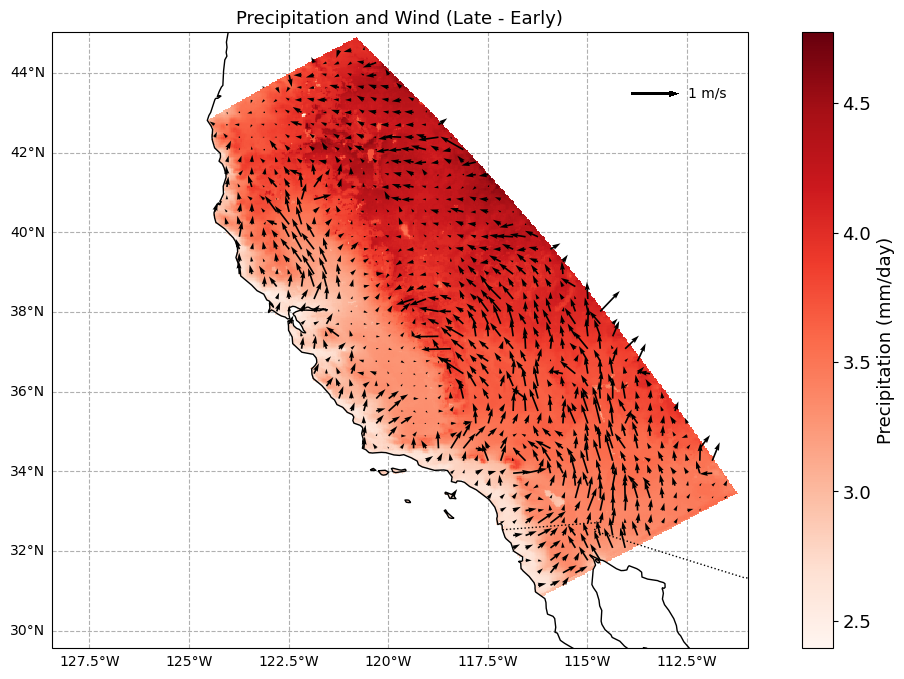

In [ ]:
# Plot the results!
map = ccrs.PlateCarree()

# Specify "step" for subsampling wind data
step = 10

# Create figure/axis objects, use the map object to specify associated projection
fig, ax = plt.subplots(figsize=(14, 8), subplot_kw={"projection": map})
# Plot temperature data on the axes using the coolwarm colormap
plot = ax.pcolormesh(cesm2_wrfprec_ensmn.lon, cesm2_wrfprec_ensmn.lat, cesm2_wrfprec_vals, 
                    transform=map, cmap="YlOrRd", zorder=5)
                    # vmin=-1.5, vmax=5)

# Plot u10/v10 vectors using quiver
lonvals = cesm2_wrfprec_ensmn.lon.values
latvals = cesm2_wrfprec_ensmn.lat.values

wnd = ax.quiver(lonvals[::step], latvals[::step], 
                cesm2_wrfu10_vals[::step, ::step], cesm2_wrfv10_vals[::step, ::step],
                transform=map, angles='xy', scale=15, zorder=6)

# Create quiver key for scale
qk = ax.quiverkey(wnd, 0.9, 0.9, 1, label='1 m/s', labelpos='E')

# Add colorbar and label it
cbar = plt.colorbar(plot, ax=ax)
cbar.set_label("Precipitation (mm/day)", fontsize=13)
cbar.ax.tick_params(labelsize=13)

# Add coastline/border lines
ax.add_feature(cfeature.COASTLINE, zorder=7)
ax.add_feature(cfeature.BORDERS, linestyle=":", zorder=8)

# Add grid lines
ax.set_axisbelow(True) # Set below the bars
gl = ax.gridlines(draw_labels=True, linestyle="--", zorder=0) 
gl.top_labels = False
gl.right_labels = False

# Set font size for x, y-axis labels
# gl.xlabel_style = {'size': 20}
# gl.ylabel_style = {'size': 20}

# Add title, show plot
ax.set_title("Precipitation and Wind (Late - Early)", fontsize= 13)
plt.show()

There you have it! Being able to make vector plots is a nice tool to have in your quiver :)